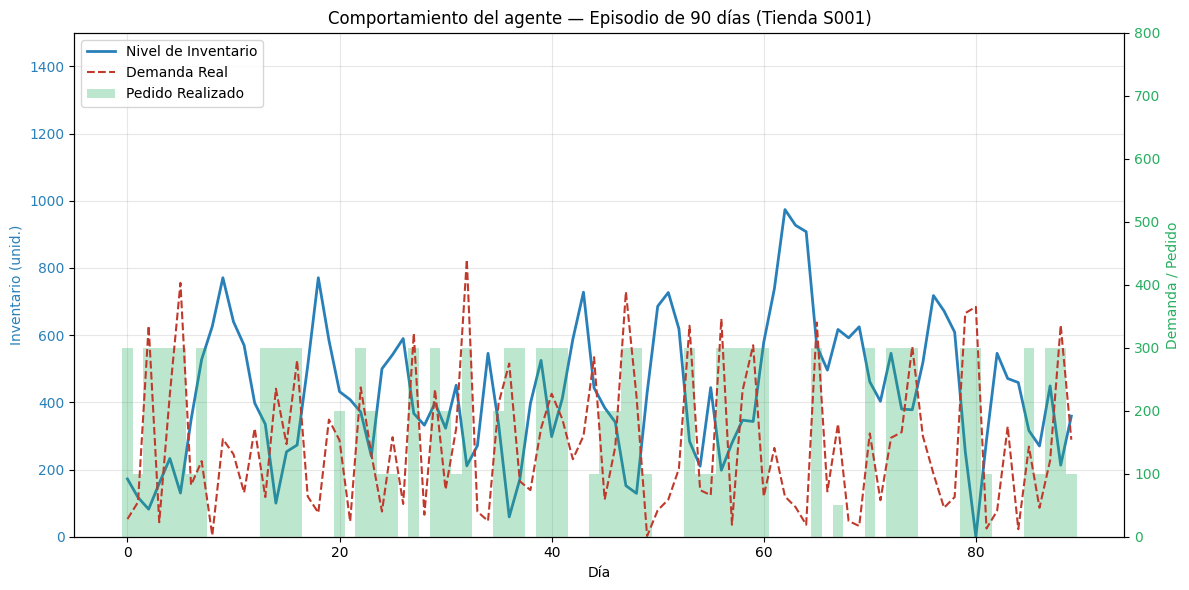

In [ ]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

# Llamar al entorno
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.environment_dqn import RetailEnvDQN

# 1. Configuración
MODELO_PATH = "../results/models/dqn/best_model/best_model.zip"
STORES_PATH = "../data/stores.pkl"

# 2. Cargar tiendas (stores)
with open(STORES_PATH, "rb") as f:
    stores = pickle.load(f)

TEST_STORE = list(stores.keys())[0]


# 3. Crear entorno de evaluación
env = RetailEnvDQN(stores_dict=stores)

# Modo evaluación:
env.disable_random_reset = True
env.fixed_store = TEST_STORE
env.fixed_start = 0    # iniciar en el día 0
env.duracion_simulacion = 90  # para asegurar ventana de 90 días


# 4. Cargar el modelo entrenado
model = DQN.load(MODELO_PATH)

# 5. Función para correr y registrar un episodio
def obtener_datos_episodio(env, model):
    obs, _ = env.reset()
    done = False
    
    hist_inventario = []
    hist_demanda = []
    hist_pedidos = []
    dias = []
    dia_actual = 0
    
    while not done:
        # Usar el modelo de forma determinista (sin aleatoriedad)
        action, _ = model.predict(obs, deterministic=True)
        
        obs, _, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # Guardar datos reales del diccionario 'info'
        hist_inventario.append(info['inventario'])
        hist_demanda.append(info['demanda']) 
        hist_pedidos.append(info['pedido_qty'])
        dias.append(dia_actual)
        dia_actual += 1
        
    return dias, hist_inventario, hist_demanda, hist_pedidos

dias, inv, dem, ped = obtener_datos_episodio(env, model)

# 6. Generar el Gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Inventario
ax1.plot(dias, inv, color="#2980b9", linewidth=2, label="Nivel de Inventario")
ax1.set_xlabel("Día")
ax1.set_ylabel("Inventario (unid.)", color="#2980b9")
ax1.tick_params(axis="y", labelcolor="#2980b9")
ax1.set_ylim(0, env.max_inventario)
ax1.grid(True, alpha=0.3)

# Eje secundario
ax2 = ax1.twinx()

# Demanda
ax2.plot(dias, dem, color="#c0392b", linestyle="--", label="Demanda Real")

# Pedidos del Agente
ax2.bar(dias, ped, color="#27ae60", alpha=0.3, width=1.0, label="Pedido Realizado")

ax2.set_ylabel("Demanda / Pedido", color="#27ae60")
ax2.tick_params(axis="y", labelcolor="#27ae60")
ax2.set_ylim(0, max(env.action_values))

# Leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title(f"Comportamiento del agente — Episodio de 90 días (Tienda {TEST_STORE})")
plt.tight_layout()
plt.savefig("../results/plots/benchmark/episodio_detalle.png")
plt.show()
